Материалы Юстины Ивановой: https://github.com/yustinaivanova/netology_statistics_february_20

# Домашняя работа №7.

* Написать модель Random Forest на датасет больных сердечными болезнями (можно почистить от выбросов).

In [ ]:
url="http://yustiks.ru/dataset/cardio_train.csv"
data=pd.read_csv(url,sep=";")
data.tail()

Данный датасет разобран в начале лекции 5. 

Модель Random Forest при обучении дает такой метод как feature importance, используя его, можно оценить, какой параметр **максимально** влияет на болезнь.

* Сделать вывод о том, какой атрибут оказывает значительное влияение на наличие или отсутствие болезни.

Основная задача: определить, что влияет на сердечную болезнь больше всего. Например, выдвигая гипотезу о том, что тот кто курит, болеет чаще, мы сравниваем курящих пациентов с некурящими, и определяя насколько статистически значимы выборки, делаем вывод, что одна выборка статистически отличима от другой (или неотличима).
    Выдвигаем гипотезу на самый важный атрибут, полученный из feature_importance (Random_Forest). И оцениваем гипотезу. И делаем вывод.

In [1]:
import io
import requests
import ssl
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels as sm
import matplotlib
import pandas as pd
import io
import requests
import ssl
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn import preprocessing
from scipy.stats import t
from scipy.stats import norm
from scipy import stats
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels as sm
import matplotlib
import pandas as pd
import io
import requests
import ssl
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn import preprocessing
from scipy.stats import t
from scipy.stats import norm
from scipy import stats
from pylab import *

# Turn off code warnings (this is not recommended for routine use)
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [26]:
import ssl
# следующая строчка подключает сертификат для защищенного соединения
ssl._create_default_https_context = ssl._create_unverified_context
url="http://yustiks.ru/dataset/cardio_train.csv"
data=pd.read_csv(url,sep=";")
data.head()


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [27]:
# для начала выделим столбцы для предсказания
df = data.iloc[:,1:12]
df.head()


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,18393,2,168,62.0,110,80,1,1,0,0,1
1,20228,1,156,85.0,140,90,3,1,0,0,1
2,18857,1,165,64.0,130,70,3,1,0,0,0
3,17623,2,169,82.0,150,100,1,1,0,0,1
4,17474,1,156,56.0,100,60,1,1,0,0,0


In [28]:
# нормализуем параметры
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
np_scaled = min_max_scaler.fit_transform(df)
df_norm = pd.DataFrame(np_scaled)
df_norm.head()


,0,1,2,3,4,5,6,7,8,9,10
0,0.176152,1.0,0.158974,-0.452632,-0.967842,-0.972900,-1.0,-1.0,-1.0,-1.0,1.0
1,0.460317,-1.0,0.035897,-0.210526,-0.964131,-0.971093,1.0,-1.0,-1.0,-1.0,1.0
2,0.248006,-1.0,0.128205,-0.431579,-0.965368,-0.974706,1.0,-1.0,-1.0,-1.0,-1.0
3,0.056911,1.0,0.169231,-0.242105,-0.962894,-0.969286,-1.0,-1.0,-1.0,-1.0,1.0
4,0.033837,-1.0,0.035897,-0.515789,-0.969079,-0.976513,-1.0,-1.0,-1.0,-1.0,-1.0


In [29]:
# присвоим изначальное наименование столбцов
headers = list(df.columns.values)
df_norm.columns = headers
df_norm.head()


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,0.176152,1.0,0.158974,-0.452632,-0.967842,-0.972900,-1.0,-1.0,-1.0,-1.0,1.0
1,0.460317,-1.0,0.035897,-0.210526,-0.964131,-0.971093,1.0,-1.0,-1.0,-1.0,1.0
2,0.248006,-1.0,0.128205,-0.431579,-0.965368,-0.974706,1.0,-1.0,-1.0,-1.0,-1.0
3,0.056911,1.0,0.169231,-0.242105,-0.962894,-0.969286,-1.0,-1.0,-1.0,-1.0,1.0
4,0.033837,-1.0,0.035897,-0.515789,-0.969079,-0.976513,-1.0,-1.0,-1.0,-1.0,-1.0


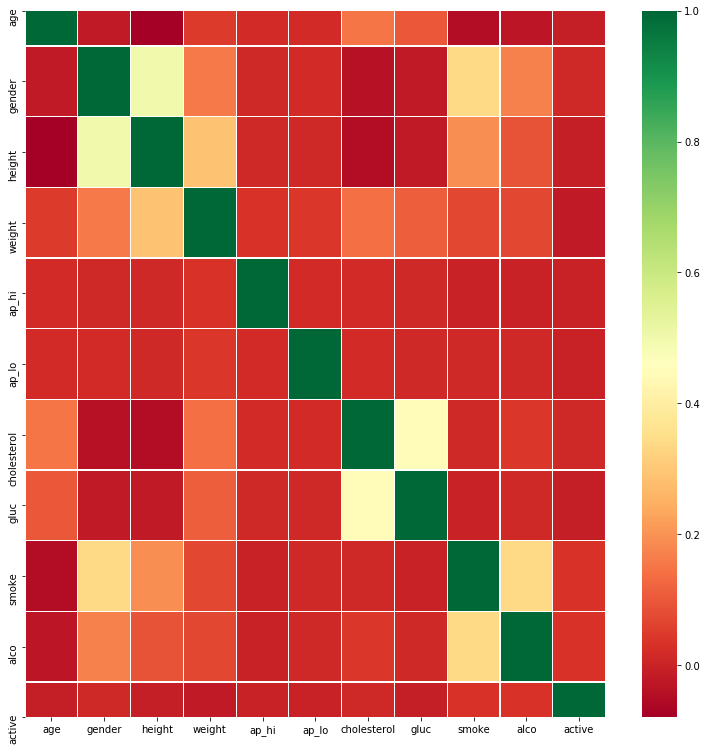

In [30]:
# построим матрицу корреляций
f, ax = plt.subplots(figsize=(13, 13))
corr = np.round_(df_norm.corr(), decimals=2)
sns.heatmap(corr,annot=False,cmap='RdYlGn',linewidths=0.2)
# на матрице видно, что сильно коррелируемых значений нет

In [31]:
# для randomforest выделим данные для входы и вывода
output_y = data.iloc[:,12:]
input_x = df_norm
#input_x = df

In [37]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
targets=(output_y.iloc[:,:]==1).idxmax(1)
print(targets.value_counts())
Y=le.fit_transform(targets)

from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
targets=(output_y.iloc[:,:]==1)
#print(targets.value_counts())
Y=le.fit_transform(targets)


cardio    70000
dtype: int64


In [38]:
from sklearn.model_selection import train_test_split
X_train_22, X_test_22, y_train_22, y_test_22 = train_test_split(input_x, Y, test_size=0.2)

In [39]:
from sklearn.ensemble import RandomForestClassifier

# создаем модель деревья решений
# выбираем 100 деревьев в качестве параметра
model=RandomForestClassifier(n_estimators=100)

# обучаем модель
model.fit(X_train_22,y_train_22)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

No handles with labels found to put in legend.


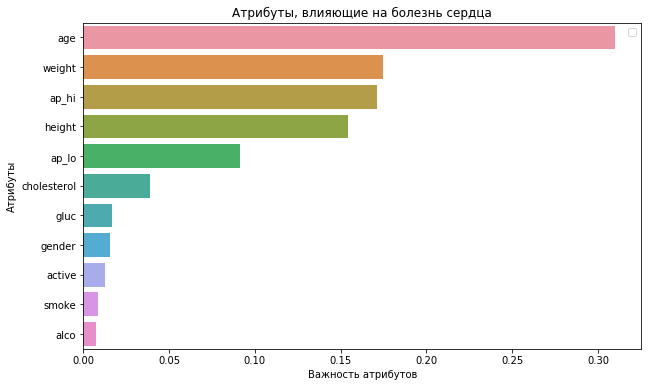

[('age', 0.30979250050850743),
 ('gender', 0.015312105910338877),
 ('height', 0.15422285504305142),
 ('weight', 0.17456068843284228),
 ('ap_hi', 0.17104239253588982),
 ('ap_lo', 0.09107892873258497),
 ('cholesterol', 0.038728248887597225),
 ('gluc', 0.016551920575126337),
 ('smoke', 0.008590225537032892),
 ('alco', 0.0073303330002621615),
 ('active', 0.012789800836766403)]

In [40]:

feature_imp = pd.Series(model.feature_importances_,index=headers).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Атрибуты, влияющие на болезнь сердца")
plt.legend()
plt.show()
list(zip(headers, model.feature_importances_))

In [41]:
# посчитаем качество модели
model_pred = model.predict(X_test_22)

print(classification_report(y_test_22, model_pred))

model.score(X_test_22, y_test_22)

              precision    recall  f1-score   support

           0       0.71      0.73      0.72      6998
           1       0.72      0.71      0.71      7002

    accuracy                           0.72     14000
   macro avg       0.72      0.72      0.72     14000
weighted avg       0.72      0.72      0.72     14000



0.7161428571428572

In [49]:
# точность предсказания в нашем случае 71,3% , а наиболее важным атрибутом, влиящим на заболевание сердца, 
# является возраст

# теперь проверим гипотезу , что старые люди чаще заболевают чаще , чем молодые

import researchpy as rp
# Showing descriptive statistics from researchpy.summary_cont()
rp.summary_cont(data.groupby('cardio')['age'])

,N,Mean,SD,SE,95% Conf.,Interval
cardio,,,,,,
0,35021,18881.623711,2473.925337,13.219722,18855.712687,18907.534736
1,34979,20056.813031,2315.927546,12.382869,20032.542261,20081.083801


In [47]:
descriptives, results = rp.ttest(data.cardio, data.age)
results

,Independent t-test,results
0,Difference (cardio - age) =,-19468.3661
1,Degrees of freedom =,139998.0000
2,t =,-2087.6855
3,Two side test p value =,0.0000
4,Difference < 0 p value =,0.0000
5,Difference > 0 p value =,1.0000
6,Cohen's d =,-11.1591
7,Hedge's g =,-11.1591
8,Glass's delta =,-38936.4611
9,r =,0.9843


In [ ]:
# в результате pvalue = 0, это говорит о том что гипотеза верна и между выборками имеются статистические различия